In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

from collections import defaultdict

# colab: !pip install surprise
# window(prompt): conda install -c conda-forge scikit-surprise
import surprise
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from surprise import SVD

from sklearn.feature_extraction.text import TfidfVectorizer

import os

os.chdir('D:\\Category\\Data\Kaggle\\571_1094_bundle_archive')
print(os.getcwd())

D:\Category\Data\Kaggle\571_1094_bundle_archive


In [2]:
item = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

print(item.shape)
print(rating.shape)

(12294, 7)
(7813737, 3)


# Item

In [84]:
item

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [85]:
for i in range(item.shape[1]):
  print(item.columns[i])
  print('Unique values are', len(item.iloc[:, i].unique()))
  print('---------------------')

anime_id
Unique values are 12294
---------------------
name
Unique values are 12292
---------------------
genre
Unique values are 3265
---------------------
type
Unique values are 7
---------------------
episodes
Unique values are 187
---------------------
rating
Unique values are 599
---------------------
members
Unique values are 6706
---------------------


In [86]:
# Does animation id start from 0 and stops at 12294?
# No!!!
print(item.anime_id.min())
print(item.anime_id.max())

1
34527


# Rating

In [87]:
rating

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [88]:
for i in range(rating.shape[1]):
  print(rating.columns[i])
  print('Unique values are', len(rating.iloc[:, i].unique()))
  print('---------------------')

# Not all animations are watched.

user_id
Unique values are 73515
---------------------
anime_id
Unique values are 11200
---------------------
rating
Unique values are 11
---------------------


In [ ]:
rating.isna().sum()
# NO NaN

user_id     0
anime_id    0
rating      0
dtype: int64

# data reduction
As the data is too big, we should remove not popular items.

## 1) item without rate

In [6]:
item.isna().sum() # == is.null()
# There're NaN's in rating

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [3]:
item_redu = item[item.rating.isna()==False]
item_redu.shape[0]

12064

## 2) item with low rate

In [4]:
# Dstribution of rating
item_redu_rate = item_redu.rating.value_counts().sort_index()

trace = go.Bar(x=item_redu_rate.index,
              text=['{:.1f}%'.format(val) for val in (item_redu_rate.values/item_redu.shape[0]*100)],
              textposition='auto',
              textfont=dict(color='#000000'),
              y=item_redu_rate.values)

# Create layout
layout = dict(title='Distribution of {} book-ratings'.format(item_redu.shape[0]),
             xaxis = dict(title='Rating'),
             yaxis = dict(title='Count'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [5]:
# Remove row score items which are not favored by users.
item_redu = item_redu[item_redu.rating > 6]
item_redu.shape[0]

8564

## 3) User rate -1
To ease the problem, remove -1 scores

In [6]:
rate_redu = rating[rating.rating !=-1]
rate_redu.shape[0]

6337241

## 4) User & item with low rate
Alike with item, remove below 5

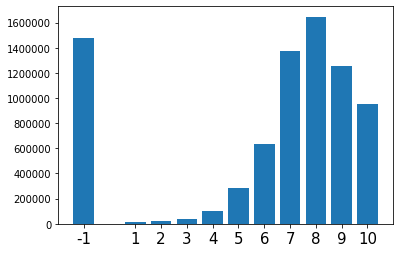

In [7]:
rate_per_score = rating.groupby('rating').size().reset_index()

plt.bar(rate_per_score['rating'], rate_per_score[0])
tmp = plt.xticks(rate_per_score['rating'], rate_per_score['rating'], fontsize=15)

In [8]:
# Dstribution of rating
rate_redu_rate = rate_redu.rating.value_counts().sort_index()

trace = go.Bar(x=rate_redu_rate.index,
              text=['{:.1f}%'.format(val) for val in (rate_redu_rate.values/rate_redu.shape[0]*100)],
              textposition='auto',
              textfont=dict(color='#000000'),
              y=rate_redu_rate.values)

# Create layout
layout = dict(title='Distribution of {} book-ratings'.format(rate_redu.shape[0]),
             xaxis = dict(title='Rating'),
             yaxis = dict(title='Count'))

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [9]:
rate_redu = rate_redu[rate_redu.rating>= 6]
rate_redu.shape

(5868892, 3)

In [10]:
# merge rate_redu & item_redu
rate_redu = pd.merge(rate_redu, item_redu, how='inner', left_on='anime_id', right_on='anime_id')
rate_redu

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
2,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
3,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
4,17,8074,7,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
...,...,...,...,...,...,...,...,...,...
5822004,69964,23585,7,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life",Special,2,6.14,138
5822005,71038,7532,6,Kuroi Kikori to Shiroi Kikori,Fantasy,Movie,1,6.20,179
5822006,71792,25833,6,Zephyr,"Drama, Music",Special,1,6.37,1478
5822007,73206,25833,8,Zephyr,"Drama, Music",Special,1,6.37,1478


## 5) item with only one rate

In [8]:
# There are many item that user has rated once.
(rate_redu.groupby('anime_id').size()==1).sum()

321

In [11]:
rate_redu_ani = pd.DataFrame(rate_redu.groupby('anime_id').size())
rate_redu_ani = rate_redu_ani[rate_redu_ani[0] != 1].reset_index()
rate_redu_ani

,anime_id,0
0,1,13277
1,5,5702
2,6,9207
3,7,1998
4,8,273
...,...,...
7134,34240,1220
7135,34283,11
7136,34325,14
7137,34349,3


In [12]:
# merge rate_redu & rate_redu_ani
rate_redu = pd.merge(rate_redu, rate_redu_ani, how='inner', left_on='anime_id', right_on='anime_id')
rate_redu

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,0
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751
1,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751
2,12,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751
3,14,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751
4,17,8074,7,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751
...,...,...,...,...,...,...,...,...,...,...
5821683,69522,32534,7,Monkey King: Hero Is Back,"Adventure, Fantasy, Historical, Martial Arts, ...",Movie,1,7.08,499,2
5821684,64623,32826,6,Yuuki no Baton,Music,Music,1,6.16,549,2
5821685,66118,32826,6,Yuuki no Baton,Music,Music,1,6.16,549,2
5821686,71792,25833,6,Zephyr,"Drama, Music",Special,1,6.37,1478,2


## 6) User with only one rate

In [11]:
# There are many users that has only one record.
(rate_redu.groupby('user_id').size()==1).sum()

3260

In [13]:
rate_redu_user = pd.DataFrame(rate_redu.groupby('user_id').size())
rate_redu_user = rate_redu_user[rate_redu_user[0] != 1].reset_index()
rate_redu_user

,user_id,0
0,1,4
1,3,87
2,5,157
3,7,319
4,8,11
...,...,...
66205,73511,15
66206,73512,11
66207,73513,31
66208,73515,176


In [14]:
rate_redu = pd.merge(rate_redu, rate_redu_user, how='inner', right_on='user_id', left_on='user_id')
rate_redu

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,0_x,0_y
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751,4
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660,11244,4
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100,24263,4
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657,7323,4
4,3,8074,6,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751,87
...,...,...,...,...,...,...,...,...,...,...,...
5818423,48843,1879,8,Midnight Eye: Gokuu,"Action, Mystery, Sci-Fi, Seinen",OVA,1,6.58,2670,57,3
5818424,48843,1880,8,Midnight Eye: Gokuu II,"Action, Adventure, Mystery, Sci-Fi, Seinen, Su...",OVA,1,6.44,1688,47,3
5818425,48843,3509,7,Riki-Oh: Toukatsu Jigoku,"Action, Martial Arts, Seinen, Super Power",OVA,1,6.25,1319,24,3
5818426,29613,1598,6,Casshern: Robot Hunter,"Adventure, Mecha, Sci-Fi",OVA,4,6.53,4497,119,2


# Process for recommendation
## 1) Duplicated row

In [23]:
# There are 7 duplicated rows -> see 14 rows
print(rate_redu.shape[0])
print(rate_redu[['user_id', 'anime_id']].drop_duplicates().shape[0])

5818428
5818422


In [15]:
rate_redu[(rate_redu.user_id==42653) & ((rate_redu.anime_id== 1575) | (rate_redu.anime_id==2001) | (rate_redu.anime_id==11757) | (rate_redu.anime_id==16498) | (rate_redu.anime_id==20507)
        | (rate_redu.anime_id==22319) | (rate_redu.anime_id==23283))]
# No -1 score -> mean

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,0_x,0_y
3904539,42653,11757,8,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100,24263,87
3904550,42653,16498,8,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229,24785,87
3904551,42653,16498,8,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229,24785,87
3904555,42653,20507,7,Noragami,"Action, Adventure, Shounen, Supernatural",TV,12,8.17,515378,12286,87
3904556,42653,20507,9,Noragami,"Action, Adventure, Shounen, Supernatural",TV,12,8.17,515378,12286,87
3904559,42653,22319,8,Tokyo Ghoul,"Action, Drama, Horror, Mystery, Psychological,...",TV,12,8.07,618056,14404,87
3904560,42653,22319,6,Tokyo Ghoul,"Action, Drama, Horror, Mystery, Psychological,...",TV,12,8.07,618056,14404,87
3904573,42653,1575,8,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,23808,87
3904574,42653,1575,6,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151,23808,87
3904588,42653,2001,8,Tengen Toppa Gurren Lagann,"Action, Adventure, Comedy, Mecha, Sci-Fi",TV,27,8.78,562962,16725,87


In [16]:
dup_user = rate_redu[rate_redu.user_id==42653].groupby(['user_id', 'anime_id']).mean().reset_index()
dup_user

,user_id,anime_id,rating_x,rating_y,members,0_x,0_y
0,42653,1,8.0,8.82,486824.0,13277.0,87.0
1,42653,5,9.0,8.40,137636.0,5702.0,87.0
2,42653,71,7.0,7.81,256325.0,9321.0,87.0
3,42653,72,8.0,8.21,171086.0,7534.0,87.0
4,42653,73,7.0,8.06,155340.0,6598.0,87.0
...,...,...,...,...,...,...,...
76,42653,23283,8.5,8.26,342893.0,8332.0,87.0
77,42653,25161,8.0,8.09,30516.0,1080.0,87.0
78,42653,25781,9.0,8.45,92543.0,1907.0,87.0
79,42653,27899,6.0,7.52,408357.0,8476.0,87.0


In [17]:
no_dup = pd.merge(rate_redu[rate_redu.user_id != 42653], dup_user, how = 'outer')
no_dup

C:\Users\raise\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1108: UserWarning:

You are merging on int and float columns where the float values are not equal to their int representation



,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members,0_x,0_y
0,1,8074,10.0,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751,4
1,1,11617,10.0,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660,11244,4
2,1,11757,10.0,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100,24263,4
3,1,15451,10.0,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657,7323,4
4,3,8074,6.0,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892,17751,87
...,...,...,...,...,...,...,...,...,...,...,...
5818417,42653,23283,8.5,NaN,NaN,NaN,NaN,8.26,342893,8332,87
5818418,42653,25161,8.0,NaN,NaN,NaN,NaN,8.09,30516,1080,87
5818419,42653,25781,9.0,NaN,NaN,NaN,NaN,8.45,92543,1907,87
5818420,42653,27899,6.0,NaN,NaN,NaN,NaN,7.52,408357,8476,87


In [18]:
no_dup_small = no_dup.iloc[:1000000, :] # need large memory
u_i = no_dup_small.set_index(['user_id', 'anime_id']).unstack()

In [19]:
u_i.iloc[range(20), range(20)].fillna("")

rating_x                                                            
anime_id       1  5  6  7  8  15 16  17 18  19  20 22 23 24 25 26 27 28 29 30
user_id                                                                      
1                                                                            
3                                                8                           
12                                                                           
14                                                                           
17                    7                     10                              9
24                                                                          8
27                                                                           
30                                                                           
40                                       9                                   
41                    9                         10                           
48                                                                           
52                             9                                             
61                                               7                           
62                                               7                           
68              8                                            7               
73                                           7                              8
75                                9  10  8                                   
98                                                                           
100                                                                          
104                                              9

# Collaborative Filter

In [20]:
# Too big
no_dup = no_dup[['user_id', 'anime_id', 'rating_x']]
out = random.sample(range(no_dup.shape[0]), 10000)
small = no_dup.loc[out, ]
small

,user_id,anime_id,rating_x
4394923,44254,2116,6.0
999296,24684,8995,8.0
1111282,26951,12189,9.0
605795,16369,11285,6.0
2923419,73437,199,10.0
...,...,...,...
3374365,361,16005,9.0
226108,5908,1096,7.0
2979506,8951,9989,10.0
4894168,201,25013,8.0


In [21]:
reader = surprise.Reader(rating_scale=(6, 10))
data = surprise.Dataset.load_from_df(small, reader)

In [22]:
pd.DataFrame(data.raw_ratings).head(5)

,0,1,2,3
0,44254,2116,6.0,None
1,24684,8995,8.0,None
2,26951,12189,9.0,None
3,16369,11285,6.0,None
4,73437,199,10.0,None


In [23]:
sim_options={'name':'msd'} # , 'user_based':True, 'min_support':1
reco_msd = surprise.KNNBasic(sim_options=sim_options)

In [24]:
cross_validate(reco_msd, data)['test_rmse'].mean()
# 10000, 1.23xx
# When used 20000, 3.xxx
# When used 30000, 1.3xx
# When used 40000, 1.2xx

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


1.228978252882221

In [25]:
# Item based
sim_options={'name':'msd', 'user_based':False} #, 'min_support':1
reco_msd = surprise.KNNBasic(sim_options=sim_options)

In [26]:
cross_validate(reco_msd, data, verbose=True)['test_rmse'].mean()
# With verbose, we can see the summarized results.

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2301  1.2126  1.2271  1.2519  1.2235  1.2290  0.0129  
MAE (testset)     1.0125  0.9938  1.0066  1.0343  1.0019  1.0098  0.0137  
Fit time          0.15    0.15    0.12    0.13    0.17    0.14    0.02    
Test time         0.02    0.02    0.03    0.02    0.03    0.02    0.00    


1.2290411939742483

## top 5
Offline 방식으로 별도 테이블을 만들어서 저장하고, 해당 사용자 로그인시 웹에서 추천

In [27]:
# Dataset.folds() ~= DatasetAutoFolds.build_full_trainset() 
train = data.build_full_trainset()
reco_msd.fit(train)
# 50000 is too much.

Computing the msd similarity matrix...
Done computing similarity matrix.


In [28]:
#test = train.build_anti_testset()
test= train.build_testset()
predictions = reco_msd.test(test) # predict -> data frame
# 5000 trainset is not enough to make neighbors.

In [29]:
test # 3rd attribute is global mean

[(44254, 2116, 6.0),
 (24684, 8995, 8.0),
 (24684, 60, 9.0),
 (26951, 12189, 9.0),
 (16369, 11285, 6.0),
 (16369, 25397, 7.0),
 (73437, 199, 10.0),
 (2176, 8917, 8.0),
 (27843, 15225, 8.0),
 (21351, 23421, 7.0),
 (21351, 18179, 8.0),
 (70830, 10218, 6.0),
 (70830, 23199, 7.0),
 (70830, 185, 8.0),
 (59317, 2251, 7.0),
 (47763, 2951, 10.0),
 (36096, 31043, 10.0),
 (34905, 9181, 8.0),
 (35138, 2966, 10.0),
 (35138, 974, 7.0),
 (47316, 11491, 9.0),
 (50131, 4814, 10.0),
 (49801, 6045, 7.0),
 (57881, 659, 10.0),
 (47268, 16706, 10.0),
 (60537, 2129, 9.0),
 (39362, 12291, 9.0),
 (39362, 18153, 8.0),
 (41401, 102, 10.0),
 (19945, 6325, 9.0),
 (19945, 11179, 8.0),
 (44384, 28497, 7.0),
 (37253, 586, 8.0),
 (37253, 10030, 8.0),
 (18690, 1818, 7.0),
 (44352, 3859, 9.0),
 (44352, 22535, 8.0),
 (18929, 10863, 10.0),
 (18929, 12471, 9.0),
 (55132, 427, 9.0),
 (29577, 8937, 8.0),
 (29577, 6045, 8.0),
 (29577, 14735, 6.0),
 (29577, 3588, 7.0),
 (29577, 31580, 8.0),
 (29577, 15117, 8.0),
 (11493, 1027

In [30]:
predictions

[Prediction(uid=44254, iid=2116, r_ui=6.0, est=6, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=24684, iid=8995, r_ui=8.0, est=8.333333333333334, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=24684, iid=60, r_ui=9.0, est=8.666666666666666, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=26951, iid=12189, r_ui=9.0, est=9.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=16369, iid=11285, r_ui=6.0, est=6.333333333333333, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=16369, iid=25397, r_ui=7.0, est=6.666666666666667, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid=73437, iid=199, r_ui=10.0, est=10, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=2176, iid=8917, r_ui=8.0, est=8.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=27843, iid=15225, r_ui=8.0, est=8.0, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=213

In [31]:
pred = pd.DataFrame(predictions)
pred = pred[['uid', 'iid', 'est']]
pred

,uid,iid,est
0,44254,2116,6.000000
1,24684,8995,8.333333
2,24684,60,8.666667
3,26951,12189,9.000000
4,16369,11285,6.333333
...,...,...,...
9995,361,16005,9.000000
9996,5908,1096,7.000000
9997,8951,9989,10.000000
9998,201,25013,8.000000


In [34]:
one_user = pred.loc[pred.uid==44254, ].set_index('uid')
one_user
#sorted(one_user['est'], reverse=True)

,iid,est
uid,,
44254,2116,6.0


# Content based

In [52]:
item_redu

,anime_id,name,genre,type,episodes,rating,members,comp
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,32281
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,5114
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,28977
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9253
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,9969
...,...,...,...,...,...,...,...,...
11835,30543,Rasen Sokou no Dystopia,Hentai,OVA,2,6.01,1943,30543
11836,2375,Shusaku Replay,"Hentai, School",OVA,4,6.01,1176,2375
11837,1353,The Urotsuki,"Adventure, Demons, Fantasy, Hentai, Horror",OVA,3,6.01,1480,1353
12251,33960,Chou Do M na Hentai Mesu-tachi Otokoton Chouky...,Hentai,OVA,Unknown,8.38,161,33960


In [35]:
item_redu['comp'] = item_redu.name + item_redu.genre + item_redu.type
item_redu.comp

0        Kimi no Na wa.Drama, Romance, School, Supernat...
1        Fullmetal Alchemist: BrotherhoodAction, Advent...
2        Gintama°Action, Comedy, Historical, Parody, Sa...
3                            Steins;GateSci-Fi, ThrillerTV
4        Gintama&#039;Action, Comedy, Historical, Parod...
                               ...                        
11835                     Rasen Sokou no DystopiaHentaiOVA
11836                      Shusaku ReplayHentai, SchoolOVA
11837    The UrotsukiAdventure, Demons, Fantasy, Hentai...
12251    Chou Do M na Hentai Mesu-tachi Otokoton Chouky...
12264        Junjou Shoujo Et Cetera SpecialsHentaiSpecial
Name: comp, Length: 8564, dtype: object

In [51]:
item_redu.comp.isna().sum()

12

In [36]:
item_redu = item_redu[item_redu.comp.isna() == False]

In [37]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [39]:
comp_matrix = tfidf.fit_transform(item_redu.comp)
comp_matrix

<8552x12791 sparse matrix of type '<class 'numpy.float64'>'
	with 55651 stored elements in Compressed Sparse Row format>

# Model based

## 1) SVD

In [61]:
no_dup

,user,item,rating_x
1192083,28520,3667,9.0
23284,654,154,9.0
1187332,28433,58,6.0
5688470,36124,20787,7.0
2633849,65694,974,7.0
...,...,...,...
1395988,33192,9513,8.0
3130046,32921,17074,10.0
576382,15778,9479,8.0
2361602,58020,270,8.0


In [60]:
# Change to train format
train = data.build_full_trainset()

algo= SVD()
algo.fit(train)

test = train.build_testset()
test # Just like original dataset

[(28520, 3667, 9.0),
 (654, 154, 9.0),
 (28433, 58, 6.0),
 (36124, 20787, 7.0),
 (65694, 974, 7.0),
 (68334, 6347, 9.0),
 (41140, 521, 7.0),
 (26212, 13535, 8.0),
 (45533, 30437, 7.0),
 (58378, 876, 7.0),
 (45387, 831, 9.0),
 (35599, 21431, 7.0),
 (21110, 24625, 6.0),
 (45659, 16782, 7.0),
 (45659, 883, 9.0),
 (64021, 27831, 8.0),
 (43632, 1896, 7.0),
 (7990, 895, 7.0),
 (8532, 11111, 10.0),
 (65290, 10588, 6.0),
 (52235, 23281, 7.0),
 (15684, 340, 9.0),
 (41567, 31637, 7.0),
 (45657, 1195, 7.0),
 (52419, 1869, 10.0),
 (62802, 21995, 10.0),
 (73340, 11757, 7.0),
 (27801, 486, 6.0),
 (27801, 1827, 7.0),
 (18733, 9041, 7.0),
 (6638, 6211, 8.0),
 (20376, 9203, 7.0),
 (10602, 543, 8.0),
 (30230, 1887, 8.0),
 (65193, 16005, 8.0),
 (72681, 9253, 8.0),
 (26165, 10213, 6.0),
 (60745, 2953, 8.0),
 (8231, 10152, 6.0),
 (8231, 2131, 6.0),
 (49146, 2494, 6.0),
 (54206, 9041, 6.0),
 (54206, 14829, 7.0),
 (52046, 3323, 7.0),
 (52046, 198, 8.0),
 (52079, 3389, 6.0),
 (26139, 245, 9.0),
 (57066, 6547,

In [63]:
predictions = algo.test(test)
predictions

[Prediction(uid=28520, iid=3667, r_ui=9.0, est=8.39618003645484, details={'was_impossible': False}),
 Prediction(uid=654, iid=154, r_ui=9.0, est=8.28103914859364, details={'was_impossible': False}),
 Prediction(uid=28433, iid=58, r_ui=6.0, est=7.3712198452001125, details={'was_impossible': False}),
 Prediction(uid=36124, iid=20787, r_ui=7.0, est=7.5600151311446435, details={'was_impossible': False}),
 Prediction(uid=65694, iid=974, r_ui=7.0, est=7.706864085284347, details={'was_impossible': False}),
 Prediction(uid=68334, iid=6347, r_ui=9.0, est=8.673926118760523, details={'was_impossible': False}),
 Prediction(uid=41140, iid=521, r_ui=7.0, est=7.727434952257927, details={'was_impossible': False}),
 Prediction(uid=26212, iid=13535, r_ui=8.0, est=8.069608913514601, details={'was_impossible': False}),
 Prediction(uid=45533, iid=30437, r_ui=7.0, est=7.73968672819603, details={'was_impossible': False}),
 Prediction(uid=58378, iid=876, r_ui=7.0, est=7.860578431932097, details={'was_impossib

In [67]:
accuracy.rmse(predictions)
# Using all trainset, with same testset

RMSE: 0.8109


0.810915006813262

# Reference
* 잔재미코딩\
$\blacktriangleright$ 파이썬 surprise 라이브러리의 SVD 모델\
$\blacktriangleright$ 버전 문제 있음